<a href="https://colab.research.google.com/github/hauduong05/ML_basics/blob/main/CNN_character_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import  Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch.nn.functional as F

In [4]:
# initial hyper_parameters

batch_size = 64
learning_rate = 0.001
n_epochs = 10

In [6]:
# prepare data

data = pd.read_csv('/content/gdrive/MyDrive/hand_written/hand_written.csv', header=None)

labels = data[0].values
features = data.loc[:, data.columns != 0].values / 255

shuffle_order = list(range(len(labels)))
random.shuffle(shuffle_order)
features = features[shuffle_order]
labels = labels[shuffle_order]

X_train, y_train = features[:300000], labels[:300000]
X_val, y_val = features[300000:330000], labels[300000:330000]
X_test , y_test = features[330000:], labels[330000:]
X_train = torch.from_numpy(X_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

trainset = TensorDataset(X_train, y_train)
valset = TensorDataset(X_val, y_val)
testset = TensorDataset(X_test, y_test)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
# build model

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
    self.fc1  = nn.Linear(7*7*32, 120)
    self.fc2 = nn.Linear(120, 26)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 7*7*32)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

model = ConvNet()
l = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# train and evaluate

train_loss_hist =[]
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(n_epochs):
  loss = 0.0
  corr = 0.0
  val_l = 0.0
  val_corr = 0.0
  for data, labels in train_loader:
    data = data.view(-1, 1, 28, 28)
    outputs = model(data)
    
    optimizer.zero_grad()
    loss1 = l(outputs, labels)
    loss1.backward()
    optimizer.step()
    _, preds = torch.max(outputs, 1)
    loss += loss1.item()
    corr += torch.sum(preds == labels)
  with torch.no_grad():
    for data, labels in val_loader:
      data = data.view(-1, 1, 28, 28)
      outputs = model(data)
      loss2 = l(outputs, labels)
      _, val_preds = torch.max(outputs, 1)
      val_l += loss2.item()
      val_corr += torch.sum(val_preds == labels)
  train_loss = loss / len(train_loader)
  train_acc = corr.float()/ len(X_train)
  train_loss_hist.append(train_loss)
  train_acc_hist.append(train_acc)
  val_loss = val_l / len(val_loader)
  val_acc = val_corr.float() / len(X_val)
  val_loss_hist.append(val_loss)
  val_acc_hist.append(val_acc)
  print(f'epoch {epoch+1} : loss = {train_loss:.3f} - acc = {train_acc:.3f} - val_loss = {val_loss:.3f} - val_acc = {val_acc:.3f}')

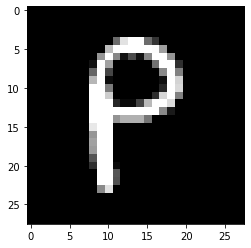

P


In [ ]:
# test

arr = [chr(i) for i in range(65, 91)]
z = list(range(len(X_test)))
random.shuffle(z)
plt.imshow(X_test[z[0]].reshape(28, 28), cmap='gray')
plt.show()
output = model(X_test[z[0]].reshape(-1, 1, 28, 28))
pred = torch.max(output, 1)[1]
print(arr[pred.item()])


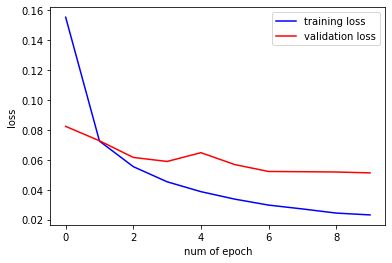

In [ ]:
# plot train loss and validation loss

fig = plt.figure()
plt.plot(np.arange(n_epochs), train_loss_hist, 'b-', label = 'training loss')
plt.plot(np.arange(n_epochs), val_loss_hist, 'r-', label = 'validation loss')
plt.xlabel('num of epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

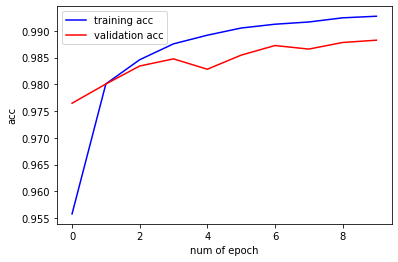

In [ ]:
# plot train accuracy and validation accuracy

fig = plt.figure()
plt.plot(np.arange(n_epochs), train_acc_hist, 'b-', label = 'training acc')
plt.plot(np.arange(n_epochs), val_acc_hist, 'r-', label = 'validation acc')
plt.xlabel('num of epoch')
plt.ylabel('acc')
plt.legend()
plt.show()